#Résolution du probleme de [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) à l'aide de SARSA et Q-Learning

## Imports


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
import progressbar


## $\epsilon$-GREEDY


### $\epsilon$-greedy

Une fonction qui chosit une action avec la stratégie $\epsilon$-greedy:
* exploite avec une probabilité $1-\epsilon$:
 * choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$:
 * choisit une action de manière uniforme sur toute les actions.

In [35]:
def epsilongreedyselection(epsilon, q_table, current_state):
        """
        Choisit une action entre 0 et len(q_table)-1
          - au hasard avec une probabilité epsilon
          - "optimal" avec une probabilité 1- epsilon
        """
        
        randchoice = random.random() #on choisit un nombre aléatoire entre 0 et 1
        
        
        if(randchoice < epsilon):
            action = random.randint(0,len(q_table[current_state])-1)
        else:
           
            max_value = np.max(q_table[current_state]) #recherche la valeur max des actions de la politique q pour l'etat en cours
            max_values_index = [] #stock l'index des actions avec la valeur max
            
            #on cherche l'index (ou les index) du max de la table q
            for index in range(0,len(q_table[current_state])):
                #si la valeur de l'indice est égale au max on garde l'indice
                if(q_table[current_state][index] == max_value):
                    max_values_index.append(index)
            
            #on choisit au hasard un indice ayant la valeur max dans l'etat courant 
            action = np.random.choice(max_values_index)

        return action

## Exploitation function

Une fonction qui va uniquement prendre la meilleur action à chaque état.
Il n'y a donc pas de phases d'exploration.

In [36]:
def exploitationonly(nb_episode, q_table, map_size):
  """
    Fonction qui va uniquement exploiter, durant {nb_episode} épisodes
    q_table est la politique q sur le probleme de FrozenLake de taille {map_size}
  """

  #Initialisation de l'environnement
  if(map_size==4):
      env = gym.make("FrozenLake-v0",  is_slippery=True)
  else:
      env = gym.make("FrozenLake8x8-v0",  is_slippery=True)
  
  winners = 0 #nombres de partie "gagner"

  bar = progressbar.ProgressBar(maxval=nb_episode, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()


  #Début des épisode
  for episode in range(nb_episode):
      current_state = env.reset() #initialise l'etat courant et l'environnement à l'état initiale
      rewards=[]
      done=False

      while not done:
          current_state, reward, done, info = env.step(np.argmax(q_table[current_state]))
          
          if(done and reward == 1):
              winners = winners + 1
          
      
      bar.update(episode+1)

  env.close()
  bar.finish()
  win_rate = (winners/nb_episode)*100
  return win_rate

## Evaluation Functions

Multiples fonctions permettant d'évaluer et d'établir une représentation graphique de l'éfficacité d'une méthode (avec sa q_table).

In [37]:
#test Q table (Exploitation uniquement)
def evaluate_q_table(nb_episode, q_table, map_size):
    win_rate = exploitationonly(nb_episode, q_table, map_size)
    print("Win rate finale : {:0.2f}".format(win_rate))

#Affiche la courbe de récompense en fonction d'un pourcentage d'épisode d'une série de récompense
def plot_progress_by_pourcentage(rewards, pourcentage):
    res = runningAvg(rewards, len(rewards)//100*pourcentage)
    title = "progress reward by {} % of episodes".format(pourcentage)
    plt.title(title)
    plt.plot(res)
    plt.ylabel('reward')
    plt.show()

#Affiche la courbe de récompense en fonction d'un nombre d'épisode d'une série de récompense
def plot_progress_by_size(rewards, size):
    res = runningAvg(rewards, size)
    title = "progress reward by {} episodes".format(size)
    plt.title(title)
    plt.plot(res)
    plt.ylabel('reward')
    plt.show()

#Affiche deux courbes de recompenses
def plot_progress_comparison(rewards_one, name1, rewards_two, name2, size):
    res_one = runningAvg(rewards_one, len(rewards_one)//100*size)
    res_two = runningAvg(rewards_two, len(rewards_two)//100*size)
    
    title = "comparison beetween {} and {}".format(name1,name2)
    
    plt.plot(res_one,'r', label=name1)
    plt.plot(res_two,'b', label=name2)
    plt.title(title)
    plt.ylabel('reward')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    
    plt.show()

## $plotQ$

Une fonction qui génère une représentation de la q_table. Chaque case indiquera la meilleure action selon la table Q et la couleur représentera la valeur de cette action.

In [38]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res


# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
  if (map_size==4):
    MAP = [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ]
  else:
    MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value)

  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j] in 'GH':
              arrow = MAP[i][j]
          elif best_policy[i, j] == 0:
              arrow = '<'
          elif best_policy[i, j] == 1:
              arrow = 'v'
          elif best_policy[i, j] == 2:
              arrow = '>'
          elif best_policy[i, j] == 3:
              arrow = '^'
          if MAP[i][j] in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
  cbar = ax.figure.colorbar(im, ax = ax)
    
  fig.tight_layout()
  plt.show() 

#FrozenLake - Politique Aléatoire


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
env = gym.make("FrozenLake8x8-v0",  is_slippery=True)
numStates = env.observation_space.n
numActions = env.action_space.n
print("Environnement avec ", numStates, " états et ", numActions, " actions")
env.reset()
nbIt=0
rew=[]
done=False
while not done:
  observation, reward, done, info = env.step(np.random.randint(4))
  env.render()
  nbIt+=1
  rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues:",rew)
env.close()

Environnement avec  64  états et  4  actions
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFH

# FrozenLake - SARSA


## Sarsa Function
Prends en parametre :  
- *nb_episode* : nombre d'épisode pour l'entrainement  
- *gamma* : le taux d'escompte
- *alpha* : le taux d'apprentissage  
- *epsilon* : pour la selection de l'action (e-greedy)  
- *map_size* : 8 pour FrozenLake8x8 ou 4 pour FrozenLake4x4 
   
Renvoie :    
- *q_table* : contient les "valeurs" des actions a dans les états s   
- *win_rate* : nombre de fois qu'un épisode s'est terminé au goal  
- *rewards* : toutes les récompenses obtenue le long de tout les épisodes  

In [40]:
def sarsafrozenlake(nb_episode, gamma, alpha, epsilon, map_size):
    
    if(map_size==4):
        env = gym.make("FrozenLake-v0",  is_slippery=True)
    else:
        env = gym.make("FrozenLake8x8-v0",  is_slippery=True)
        
    numStates = env.observation_space.n #Nb état dans l'environnement 
    numActions = env.action_space.n #Nb action dans l'environnement
    q_table = np.zeros((numStates,numActions), float) #politique de départ
    winners=0 #Nb fois qu'une partie est gagnée lors de l'entrainement
    rewards=[] #ensemble des récompenses reçues par épisodes (rewards[1] est la moyenne des récompenses perçue à l'épisode 1)
    
    bar = progressbar.ProgressBar(maxval=nb_episode, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    for episode in range(nb_episode):
        
        current_state = env.reset()
        done=False
        episode_rewards=[]
        
        #Take action with e-greedy
        action = epsilongreedyselection(epsilon, q_table, current_state)
        while not done:
            #Do this action
            next_state, reward, done, info = env.step(action)
            
            if(done and reward == 1):
                winners = winners + 1
                
            next_action = epsilongreedyselection(epsilon, q_table, next_state)
            
            #Update Q-Table by SARSA
            q_table[current_state,action] = q_table[current_state,action] + alpha * (reward + gamma*q_table[next_state,next_action] - q_table[current_state,action])
            
            
            
            current_state = next_state
            action = next_action
            
            episode_rewards.append(reward)
        
        bar.update(episode+1)      

        rewards.append(np.mean(episode_rewards))


    env.close()
    bar.finish()
    win_rate = (winners/nb_episode)*100
    print("Win rate à la fin de l'entrainement : {}".format(win_rate))
    return q_table, win_rate, rewards

## Launch training with SARSA
Entraine une table Q avec SARSA et l'affiche

[========================================================================] 100%


Win rate à la fin de l'entrainement : 27.086666666666666


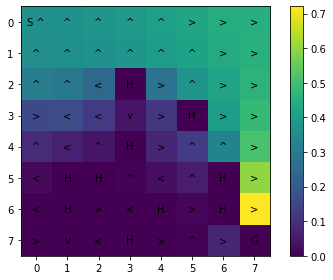

In [41]:

sarsa_q_table, win_rate, sarsa_rewards = sarsafrozenlake(nb_episode=30000,gamma=0.999
                         ,alpha=0.02, epsilon=0.2, map_size=8)
plotQ(sarsa_q_table,8)



## Exploitation SARSA
1. Affiche la courbe de progression de l'entrainement
2. Effectue une série d'episode avec unique de l'exploitation de la table Q et affiche le pourcentage de reussite 

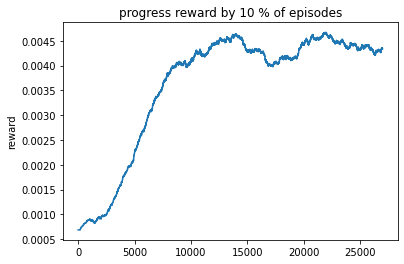

[========================================================================] 100%


Win rate finale : 83.40


In [42]:
plot_progress_by_pourcentage(sarsa_rewards,10)
evaluate_q_table(1000, sarsa_q_table, 8)

# FrozenLake - Q-learning




## Q-Learning Function
Prend en parametre :  
- *nb_episode* : nombre d'épisode pour l'entrainement  
- *gamma* : le taux d'escompte
- *alpha* : le taux d'apprentissage  
- *epsilon* : pour la selection de l'action (e-greedy)  
- *map_size* : 8 pour FrozenLake8x8 ou 4 pour FrozenLake4x4 
   
Renvoie :    
- *q_table* : contient les "valeurs" des actions a dans les états s   
- *win_rate* : nombre de fois qu'un épisode s'est terminé au goal  
- *rewards* : toutes les récompenses obtenue le long de tout les épisodes  

In [43]:
def qlearningfrozenlake(nb_episode, gamma, alpha, epsilon, map_size):
    
    if(map_size==4):
        env = gym.make("FrozenLake-v0",  is_slippery=True)
    else:
        env = gym.make("FrozenLake8x8-v0",  is_slippery=True)
        
    numStates = env.observation_space.n #Nb états dans l'environnement 
    numActions = env.action_space.n #Nb actions dans l'environnement
    q_table = np.zeros((numStates,numActions), float) #politique de départ
    winners=0 #Nb fois qu'une partie est gagnée lors de l'entrainement
    rewards=[] #ensemble des récompenses reçues par épisode (rewards[1] est la moyenne des récompenses perçue à l'épisode 1)

    bar = progressbar.ProgressBar(maxval=nb_episode, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()



    for episode in range(nb_episode):
        
        current_state = env.reset()
        episode_rewards = []
        done=False
        
        while not done:
            #Take action with e-greedy
            action = epsilongreedyselection(epsilon, q_table, current_state)
            
            #Do this action
            next_state, reward, done, info = env.step(action)
            
            if(done and reward == 1):
                winners = winners + 1
            
            
            #Update Q-Table by Q-Learning
            q_table[current_state,action] = q_table[current_state,action] + alpha * (reward + gamma*(np.max(q_table[next_state])) - q_table[current_state,action])
            
            current_state = next_state
            
            episode_rewards.append(reward)
        
        bar.update(episode+1)
        rewards.append(np.mean(episode_rewards))
        
    env.close()
    bar.finish()
    win_rate = (winners/nb_episode)*100
    print("\nWin rate à la fin de l'entrainement : {}".format(win_rate))
    return q_table, win_rate, rewards

## Training For Q-Learning Function
Entraine une table Q avec Q-Learning et l'affiche

[========================================================================] 100%



Win rate à la fin de l'entrainement : 17.496666666666666


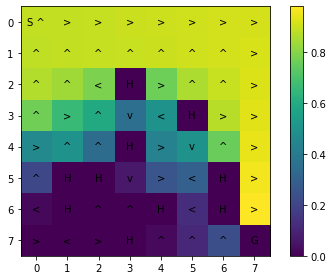

In [44]:
qlearning_q_table, win_rate, q_learning_rewards = qlearningfrozenlake(nb_episode=30000,gamma=0.999
                         ,alpha=0.02, epsilon=0.2, map_size=8)

plotQ(qlearning_q_table,8)

## Exploitation Q-Learning
1. Affiche la courbe de progression de l'entrainement
2. Effectue une série d'episode avec unique de l'exploitation de la table Q et affiche le pourcentage de reussite    

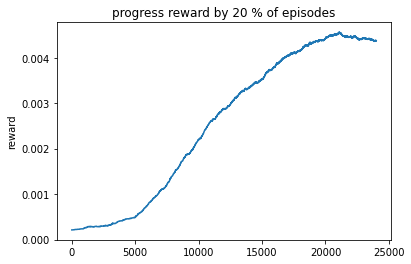

[========================================================================] 100%


Win rate finale : 89.20


In [45]:
plot_progress_by_pourcentage(q_learning_rewards,20)
evaluate_q_table(500, qlearning_q_table,8)

# Comparaison

Comparaison des politiques trouvées à l'aide de SARSA et Q-learning

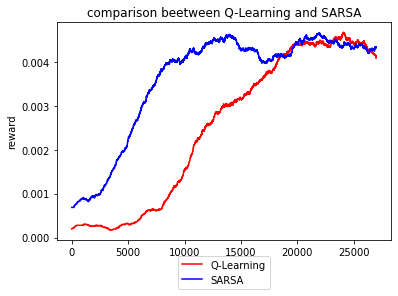

Q-Learning Q table


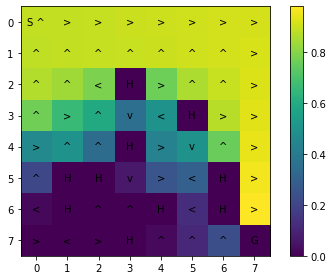

SARSA Q table


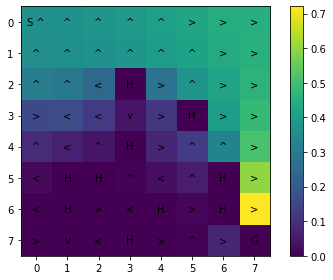

In [46]:
plot_progress_comparison(q_learning_rewards,'Q-Learning', sarsa_rewards, 'SARSA',10)

print("Q-Learning Q table")
plotQ(qlearning_q_table,8)
print("SARSA Q table")
plotQ(sarsa_q_table,8)